In [67]:
import json, os, re
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

class UnlabeledResult:
    def __init__(self, labelPath, resultPath, classes):
        df = pd.read_csv(labelPath, header=None, delimiter=' ')[[0]].rename(columns={0:"path"})
        df["key"] = [""]*len(df)
        for i in range(len(df)):
            name = df['path'][i].split("/")[-1]
            num  = re.findall("_([0-9]*).mp4",name)[0]
            name = name[:-(4+len(num))] + "0"*(3-len(num)) + num + ".mp4"
            df["key"][i] = name
        resultL = json.load(open(f"{resultPath}/result.json",'r'))
        resultL = [ max(zip(L,range(len(L)))) for L in resultL ]
        df['pred_cf'], df['pred_cls'] = zip(*resultL)
        self.df_key = df.sort_values(by=['key']).reset_index()
        self.df_cfs = df.sort_values(by=['pred_cf']).reset_index()
        self.classes = classes
        
    def plotConfDistribution(self):
        n = len(self.classes)
        X = [ f"{round(0.1*i,1)}-{round(0.1*(i+1),1)}" for i in range(10) ]
        M = np.zeros((10,n)).astype(int) # 0-0.1, 0.1-0.2, ..., 0.9-1
        for cf,cl in zip(self.df_key['pred_cf'],self.df_key['pred_cls']):
            M[int(cf/0.1)][cl] += 1
        for i in range(n):
            plt.bar(X, M[:,i:].sum(axis=1))           
        for x,y in enumerate( M.sum(axis=1) ):
            plt.annotate(y, xy=(x-0.5,y), fontsize=16)
        plt.xticks(rotation=45)
        plt.title(f"total={M.sum()}", fontsize=16)
        plt.xlabel("max class confidence", fontsize=16)
        plt.ylabel("number", fontsize=16)
        plt.legend(labels=self.classes)
        plt.grid(1)
        plt.show()
    
    def showFramesFor1Video(self, i, videoPath, get=5, pred_cf=None, pred_cls=None):
        cap    = cv2.VideoCapture(videoPath)
        frames = [ cap.read()[1] for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))) ]
        cap.release()
        print( f"i={i}, video={videoPath.split('/')[-1]}, class={pred_cls}, conf={round(pred_cf,2)}" )
        plt.figure(figsize=(5*get,4))
        for i,frame in enumerate(frames[::len(frames)//(get-1)][:(get-1)]+[frames[-1]]):
            plt.subplot(1,get,1+i)
            plt.imshow( frame[:,:,::-1] )
            plt.axis('off')
        plt.show()
    
    def visualize(self, mode, num=50, start=0):
        assert mode in ["key", "conf_inc", "conf_dec"]
        if mode=="key":
            df = self.df_key.loc[start:start+num].reset_index(drop=True)
        elif mode=="conf_inc":
            df = self.df_cfs.loc[:num]
        else:
            df = self.df_cfs.loc[len(self.df_cfs)-1-num:].reset_index(drop=True)
        for i in range(num):
            _, videoPath, _, pred_cf, pred_cls = df.loc[i]
            self.showFramesFor1Video(i, videoPath, pred_cf=pred_cf, pred_cls=pred_cls if pred_cf>0.9 else f"{pred_cls}*")
            #self.showFramesFor1Video(i, videoPath, pred_cf=pred_cf, pred_cls=pred_cls)

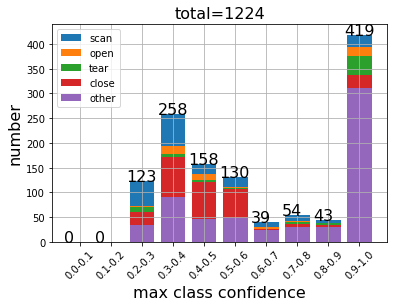

,index,path,key,pred_cf,pred_cls
0,0,/home/jovyan/data-vol-1/VideoMAE/_data/pretext...,video_20220810080429_000.mp4,0.496582,4
1,1,/home/jovyan/data-vol-1/VideoMAE/_data/pretext...,video_20220810080429_001.mp4,0.401855,4
2,34,/home/jovyan/data-vol-1/VideoMAE/_data/pretext...,video_20220810080429_002.mp4,0.337158,0
3,45,/home/jovyan/data-vol-1/VideoMAE/_data/pretext...,video_20220810080429_003.mp4,0.354980,4
4,56,/home/jovyan/data-vol-1/VideoMAE/_data/pretext...,video_20220810080429_004.mp4,0.541016,4
...,...,...,...,...,...
1219,1123,/home/jovyan/data-vol-1/VideoMAE/_data/pretext...,video_20220810084930_118.mp4,0.354736,0
1220,1124,/home/jovyan/data-vol-1/VideoMAE/_data/pretext...,video_20220810084930_119.mp4,0.284912,4
1221,1126,/home/jovyan/data-vol-1/VideoMAE/_data/pretext...,video_20220810084930_120.mp4,0.272949,4
1222,1127,/home/jovyan/data-vol-1/VideoMAE/_data/pretext...,video_20220810084930_121.mp4,0.321533,0


In [68]:
obj = UnlabeledResult("../_data/pretext_0810_10/val.csv", "../_exps/downstream_0810_10_unlabeledEval", ["scan","open","tear","close","other"])
obj.plotConfDistribution()
obj.df_key

In [1]:
#obj.visualize(mode="conf_dec")

In [2]:
#obj.visualize(mode="conf_inc", num=1224)

In [3]:
#obj.visualize(mode="key", start=750)